In [20]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.0 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip '/content/drive/MyDrive/archive_2.zip' -d '/content/data'

Archive:  /content/drive/MyDrive/archive_2.zip
replace /content/data/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [21]:
# import required packages
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
import efficientnet.keras as efn
from keras import layers

In [22]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/data/train',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/data/test',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [25]:
base_model = efn.EfficientNetB0(input_shape = (48,48,3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(7, activation='softmax')(x)

model1 = tf.keras.models.Model(base_model.input, x)

model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])

16804768/16804768 [==============================] - 1s 0us/step


In [26]:
vgg_model = model1.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
449/449 [==============================] - 55s 109ms/step - loss: 1.7610 - accuracy: 0.2944 - val_loss: 1.6055 - val_accuracy: 0.3672
Epoch 2/10
449/449 [==============================] - 43s 95ms/step - loss: 1.6909 - accuracy: 0.3261 - val_loss: 1.5943 - val_accuracy: 0.3559
Epoch 3/10
449/449 [==============================] - 42s 93ms/step - loss: 1.6748 - accuracy: 0.3332 - val_loss: 1.6040 - val_accuracy: 0.3481
Epoch 4/10
449/449 [==============================] - 43s 96ms/step - loss: 1.6650 - accuracy: 0.3403 - val_loss: 1.5556 - val_accuracy: 0.3852
Epoch 5/10
449/449 [==============================] - 41s 92ms/step - loss: 1.6520 - accuracy: 0.3449 - val_loss: 1.5636 - val_accuracy: 0.3770
Epoch 6/10
449/449 [==============================] - 41s 92ms/step - loss: 1.6408 - accuracy: 0.3531 - val_loss: 1.5449 - val_accuracy: 0.4067
Epoch 7/10
449/449 [==============================] - 41s 91ms/step - loss: 1.6390 - accuracy: 0.3535 - val_loss: 1.5224 - val_accuracy

In [27]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    plt.style.use('dark_background')
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

<ipython-input-27-37e2b4767761>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-27-37e2b4767761>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


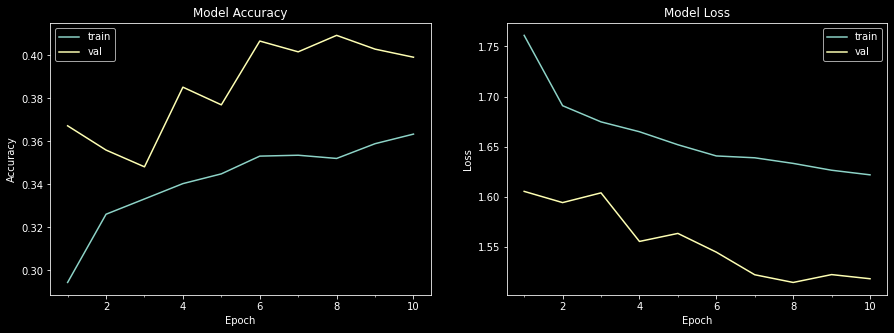

In [28]:
plot_model_history(vgg_model)

In [29]:
tr_predictions = model1.predict(train_generator)

449/449 [==============================] - 44s 95ms/step


-----------------------------------------------------------------
[[  20    0  256 2118  502  641  458]
 [   2    0   41  221   61   60   51]
 [  25    0  244 2187  528  652  461]
 [  42    0  457 3925  960 1120  711]
 [  23    0  345 2652  689  760  496]
 [  34    0  292 2579  638  771  516]
 [  15    0  204 1722  429  464  337]]


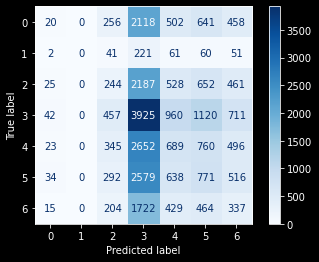

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.12      0.01      0.01      3995
           1       0.00      0.00      0.00       436
           2       0.13      0.06      0.08      4097
           3       0.25      0.54      0.35      7215
           4       0.18      0.14      0.16      4965
           5       0.17      0.16      0.17      4830
           6       0.11      0.11      0.11      3171

    accuracy                           0.21     28709
   macro avg       0.14      0.14      0.12     28709
weighted avg       0.17      0.21      0.17     28709



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [30]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(train_generator.classes, tr_predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(train_generator.classes, tr_predictions.argmax(axis=1)))
clf_report = classification_report(train_generator.classes, tr_predictions.argmax(axis=1),output_dict=True)

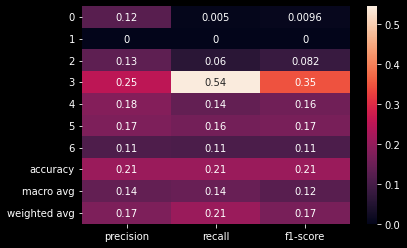

In [31]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [32]:
# do prediction on test data
predictions = model1.predict(validation_generator)

113/113 [==============================] - 4s 32ms/step


-----------------------------------------------------------------
[[  12    0   54  537  103  121  131]
 [   1    0    4   66   14   11   15]
 [   7    0   48  591  118  123  137]
 [  21    0   95 1032  188  199  239]
 [  20    0   77  695  119  137  185]
 [  18    0   74  694  134  138  189]
 [   3    0   52  464   96   93  123]]


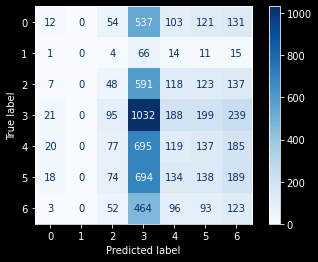

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.01      0.02       958
           1       0.00      0.00      0.00       111
           2       0.12      0.05      0.07      1024
           3       0.25      0.58      0.35      1774
           4       0.15      0.10      0.12      1233
           5       0.17      0.11      0.13      1247
           6       0.12      0.15      0.13       831

    accuracy                           0.21      7178
   macro avg       0.14      0.14      0.12      7178
weighted avg       0.17      0.21      0.16      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [33]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))
clf_report1 = classification_report(validation_generator.classes, predictions.argmax(axis=1),output_dict=True)

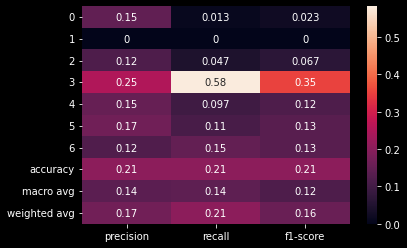

In [34]:
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True)

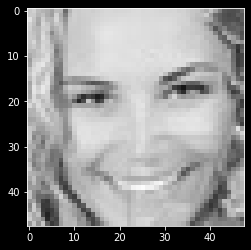

In [35]:
img = load_img("/content/data/test/happy/PrivateTest_10077120.jpg",target_size = (48,48))
img = np.array(img)
plt.imshow(img)

In [36]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,3)
result = model1.predict(img)
result = list(result[0])
print(result)
img_index = result.index(max(result))
print(emotion_dict[img_index])

1/1 [==============================] - 2s 2s/step
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Happy


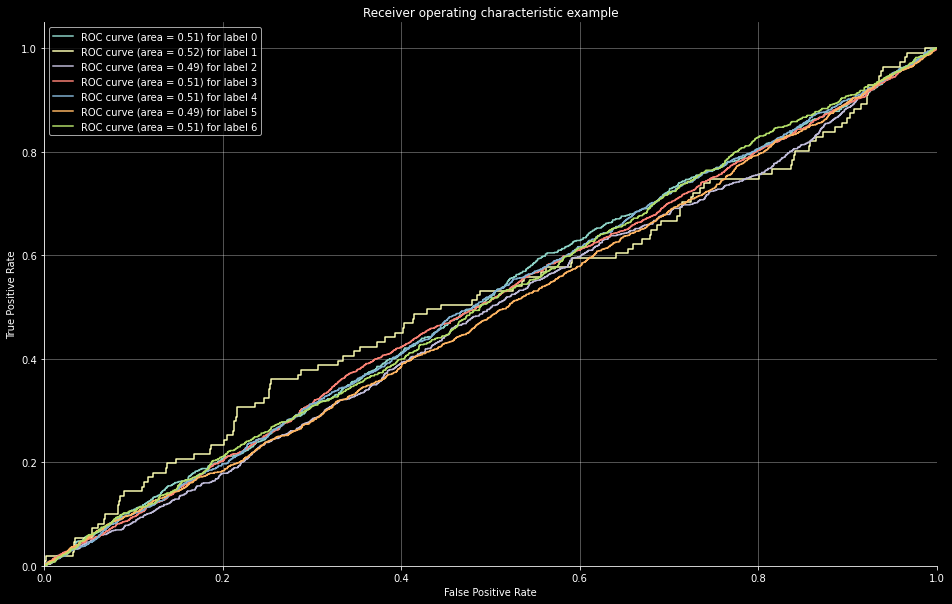

In [37]:
def plot_multiclass_roc( prediction, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(predictions, validation_generator.classes, n_classes=7, figsize=(16, 10))